<a href="https://colab.research.google.com/github/women-in-ai-ireland/September-2022-CeADAR-Group-001/blob/main/Arrivals_from_Ukraine_to_Ireland_Past_present_and_future_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ukrainian arrivals in Ireland: Past, present and future trends
**WAIPractice - Group 01** / Giulia Osti

## About
This Jupyter notebook proposes an overview of situation of the arrivals from Ukraine to Ireland. The first part explores the historical trends - based on UNHCR data, whereas the second attempts at predicting the amount of PPSN allocations needed in case the conflict between Russia and Ukraine will be protracted until the end of the first semester of 2023.

---

## The Datasets

**Source 1**
- [UNHCR, population_raw.csv](https://raw.githubusercontent.com/women-in-ai-ireland/September-2022-CeADAR-Group-001/main/UNHCR_datasets/population_raw.csv) | [original query permalink](https://www.unhcr.org/refugee-statistics/download/?url=AjD70J)

The UN refugee Agency mantains a refugee data portal which collects global  statistics on displaced populations, which are sourced primarily from governments and also from UNHCR itself. The dataset reports some 'population types' among which two recur in our analysis:

- **Asylum seekers**, people whose request for sanctuary has yet to be processed.
- **Refugees**, people fleeing conflict or persecution.



**Source 2**
- [CSO, PPSN_overview.csv](https://raw.githubusercontent.com/women-in-ai-ireland/September-2022-CeADAR-Group-001/main/CSO_datasets/PPSN-overview.csv) | UA07C01 - PPSN registrations of arrivals from Ukraine

Currently, the Central Statistics Office (CSO) maintains a dedicated information hub, [Ireland Relationships with Ukrainian People and their Economy](https://www.cso.ie/en/releasesandpublications/ep/p-uahub/irelandsrelationshipwithukrainianpeopleandtheireconomy/). In particular, they released thematic datasets and some insights on [the arrival of Ukrainians in Ireland](https://www.cso.ie/en/statistics/population/arrivalsfromukraineinireland/). 

## Required

In [267]:
# Needs to be run
'''
Else pycaret won't be running properly due to the lack of support from the most
recent version of scikit-learn
'''
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.2
!pip install pycaret

Found existing installation: scikit-learn 0.23.2
Uninstalling scikit-learn-0.23.2:
  Successfully uninstalled scikit-learn-0.23.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp38-cp38-manylinux1_x86_64.whl (6.8 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [268]:
# Import required packages
import datetime
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib import style
from pycaret.regression import *

# Define plot styles
pio.templates.default = 'plotly'
plt.style.use('seaborn-bright')

The datasets on use present three different views of the same phenomenon but, unfortunately, they cannot be aligned to form a cumulative datatset. Therefore we had to analyse and model the three of them independently.


# Part I - Historical Migration Data (UNHCR dataset)


In [248]:
# Data import
hist_unhcr = pd.read_csv('https://raw.githubusercontent.com/women-in-ai-ireland/September-2022-CeADAR-Group-001/main/UNHCR_datasets/population_raw.csv')

# Report
pdp.ProfileReport(hist_unhcr)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [219]:
# Drop extra columns
hist_unhcr = hist_unhcr.loc[:,['Year',"Refugees under UNHCR's mandate",'Asylum-seekers']]

# Datetime conversion
hist_unhcr['Year'] = pd.to_datetime(hist_unhcr['Year'], format='%Y')

# Set date as index
hist_unhcr.index = hist_unhcr.Year

# Remove Year
del hist_unhcr['Year']

# Colnames
hist_unhcr.columns = ['refugees', 'asylum_seekers']

# Create cumulative data
hist_unhcr['total'] = hist_unhcr.refugees + hist_unhcr.asylum_seekers

# Remove 2022
hist_unhcr_no22 = hist_unhcr[:23]

In [220]:
# Visualise with a scatter plot
px.line(hist_unhcr_no22, x=hist_unhcr_no22.index, y=['refugees', 'asylum_seekers', 'total'],
        title='Arrivals from Ukraine to Ireland by Population type | 1999-2021', markers=True)

In [221]:
# Visualise the full history
px.line(hist_unhcr, x=hist_unhcr.index, y=['total'],
        title='Cumulative arrivals from Ukraine to Ireland | 1999-2022', markers=True, log_y=True)

# Part II - Current Migration Data (PPSN allocation overview)


In [247]:
# Load the dataset
overview = pd.read_csv(
    'https://raw.githubusercontent.com/women-in-ai-ireland/September-2022-CeADAR-Group-001/main/CSO_datasets/PPSN-overview.csv')

# Report
pdp.ProfileReport(overview)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [224]:
# Drop extra columns
overview_pp = overview.drop(
    ['STATISTIC', 'Statistic Label', 'C03955V04713', 'UNIT'], axis=1)

# Rename
overview_pp.columns = ['week_no', 'date', 'nationality', 'value']

# Preview
overview_pp.head()

,week_no,date,nationality,value
0,2022W08,27/02/2022,All nationalities,358
1,2022W08,27/02/2022,Other nationalities with protected status,77
2,2022W08,27/02/2022,Ukrainian,281
3,2022W09,06/03/2022,All nationalities,382
4,2022W09,06/03/2022,Other nationalities with protected status,77


In [225]:
# Check nationality unique values
overview_pp.nationality.unique()

array(['All nationalities', 'Other nationalities with protected status',
       'Ukrainian'], dtype=object)

Now we will get rid of extra values and convert the date into a datetime format.


In [226]:
# Remove extra values
overview_pp = overview_pp[overview_pp.nationality == 'Ukrainian']

# Date conversion
overview_pp.date = pd.to_datetime(overview_pp.date, infer_datetime_format=True)

# Check
overview_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 2 to 110
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   week_no      37 non-null     object        
 1   date         37 non-null     datetime64[ns]
 2   nationality  37 non-null     object        
 3   value        37 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.4+ KB


In [261]:
# Plot
px.line(overview_pp, x='date', y='value',
           title="PPSN registrations of arrivals from Ukraine - CSO data", markers=True)

In [228]:
# New duplicate
overview_r = overview_pp

# Set date as index
overview_r.index = overview_r.date

# Drop week_no col
overview_r.drop(['week_no', 'nationality'], axis=1, inplace=True)

# Convert value into integer
overview_r.value = overview_r.value.astype(int)

# Upsampling
overview_r = overview_r.resample('D').mean().interpolate(method='linear')

In [229]:
# Get info
overview_r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2022-02-27 to 2022-11-06
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


In [230]:
# Check
overview_r.tail()

,value
date,
2022-11-02,60743.714286
2022-11-03,60904.285714
2022-11-04,61064.857143
2022-11-05,61225.428571
2022-11-06,61386.000000


In [262]:
# Plot resampled version
px.line(overview_r, x=overview_r.index, y='value',
           title='PPSN registrations of arrivals from Ukraine - CSO data (resampling)', markers=True)

In [232]:
# Check resampled dataset size
len(overview_r)

253

In [233]:
# Preview tail
overview_r.tail()

,value,date1
date,,
2022-11-02,60743.714286,2022-11-02
2022-11-03,60904.285714,2022-11-03
2022-11-04,61064.857143,2022-11-04
2022-11-05,61225.428571,2022-11-05
2022-11-06,61386.000000,2022-11-06


In [234]:
# Convert date into string
overview_r['date1'] = overview_r.index.astype(str)

# Unpack date
overview_r[["year", "month", "day"]] = overview_r["date1"].str.split("-", expand = True)

# Remove date column
del overview_r['date1']

# Create sequence numbering (to preserve temporal order)
overview_r['sequence'] = np.arange(1,len(overview_r)+1)

# Convert everything to integer
overview_r = overview_r.astype(int)

# Reorder the dataset
overview_r = overview_r[['sequence', 'day', 'month', 'year', 'value']]

# Preview dataset head
overview_r.head()

,sequence,day,month,year,value
date,,,,,
2022-02-27,1,27,2,2022,281
2022-02-28,2,28,2,2022,284
2022-03-01,3,1,3,2022,287
2022-03-02,4,2,3,2022,291
2022-03-03,5,3,3,2022,294


In [235]:
# Let's see what we have
overview_r.month.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [236]:
# Split data into train-test set
train = overview_r[overview_r['month'] < 9]
test = overview_r[overview_r['month'] >= 9]

# Check shapes
train.shape, test.shape

((186, 5), (67, 5))

In [237]:
# Pycaret setup
setup = setup(data = train, test_data = test, target = 'value', 
              fold_strategy = 'timeseries', numeric_features = ['sequence', 'day', 'year', 'month'], 
              fold = 3, transform_target = True, session_id = 42, silent = True, log_experiment = True, experiment_name = 'test3')

,Description,Value
0,session_id,42
1,Target,value
2,Original Data,"(186, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(186, 4)"


INFO:logs:Logging experiment in MLFlow
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['sequence', 'day',
                                                          'year', 'month'],
                                      target='value', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_n...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('

In [238]:
# Let's compare the models
best_fit = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,5282.8687,3.599069e+07,5538.4122,-5.3658,0.1610,0.1446,0.0267
knn,K Neighbors Regressor,5448.6605,3.735966e+07,5982.5025,-4.2645,0.1804,0.1487,0.0433
dt,Decision Tree Regressor,5561.2391,3.943585e+07,6160.1557,-4.5903,0.1850,0.1506,0.0300
gbr,Gradient Boosting Regressor,5608.0137,4.068247e+07,6188.9140,-4.4951,0.1889,0.1540,0.0600
et,Extra Trees Regressor,5813.3131,4.294048e+07,6385.5242,-4.9266,0.1937,0.1582,0.1767
rf,Random Forest Regressor,6121.0449,4.667821e+07,6656.2845,-5.4100,0.2047,0.1681,0.2167
ada,AdaBoost Regressor,6619.2629,5.198177e+07,7123.2029,-6.7321,0.2176,0.1798,0.1033
lightgbm,Light Gradient Boosting Machine,7977.1038,7.583023e+07,8421.7501,-9.3172,0.2790,0.2238,0.0367
lasso,Lasso Regression,17873.7878,5.841759e+08,20028.2321,-61.6256,0.3949,0.5220,0.0167
en,Elastic Net,19404.6331,7.011318e+08,21715.2822,-73.5477,0.4185,0.5693,0.0167


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(C=1.0, average=False, early_stopping=False,
                                epsilon=0.1, fit_intercept=True,
                                loss='epsilon_insensitive', max_iter=1000,
                                n_iter_no_change=5,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42,
                                regressor=PassiveAggressiveRegressor(C=1.0,
                                                                     average=False,
                                                                     early_stopping=False,
                                                                     epsilon=0.1,
                                                                     fit_intercept=True,
          

In [239]:
# Print the best fitting model
print(best_fit)

PowerTransformedTargetRegressor(C=1.0, average=False, early_stopping=False,
                                epsilon=0.1, fit_intercept=True,
                                loss='epsilon_insensitive', max_iter=1000,
                                n_iter_no_change=5,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42,
                                regressor=PassiveAggressiveRegressor(C=1.0,
                                                                     average=False,
                                                                     early_stopping=False,
                                                                     epsilon=0.1,
                                                                     fit_intercept=True,
                                                                     loss='epsilon_insensitive',
                            

So, the `Passive Aggressive Regressor` ended up to be the best match, a linear online learning model 

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=PowerTransformedTargetRegressor(C=1.0, average=False, early_stopping=False,
                                epsilon=0.1, fit_intercept=True,
                                loss='epsilon_insensitive', max_iter=1000,
                                n_iter_no_change=5,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42,
                                regressor=PassiveAggressiveRegressor(C=1.0,
                                                                     average=False,
                                                                     early_stopping=False,
                                                                     epsilon=0.1,
                                                                     fit_intercept=True,
                                                  

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

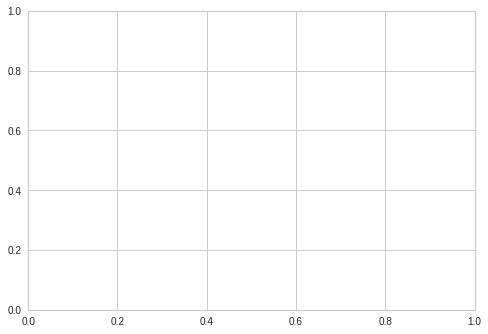

In [240]:
# Model evaluation
evaluate_model(best_fit)

## Prediction

In [241]:
# Create an empty dataframe
future = pd.DataFrame()

future['next_period']= pd.date_range(start = '2022-11-07', end = '2023-06-01', freq = 'D').astype(str)

# Date as index - will be useful later
future.index = future['next_period']

# Unpack date
future[["year", "month", "day"]] = future["next_period"].str.split("-", expand = True)

# Remove date column
del future['next_period']

# Add sequence feature - picking up from the previous numbering
future['sequence'] = np.arange(253,(253+len(future)))

# Reorder columns
future = future[['sequence', 'day', 'month', 'year']]

# Preview
future.head()

,sequence,day,month,year
next_period,,,,
2022-11-07,253,07,11,2022
2022-11-08,254,08,11,2022
2022-11-09,255,09,11,2022
2022-11-10,256,10,11,2022
2022-11-11,257,11,11,2022


In [242]:
# Predict the future trends
future_prediction = predict_model(best_fit, data=future)

# Review
future_prediction.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(C=1.0, average=False, early_stopping=False,
                                epsilon=0.1, fit_intercept=True,
                                loss='epsilon_insensitive', max_iter=1000,
                                n_iter_no_change=5,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42,
                                regressor=PassiveAggressiveRegressor(C=1.0,
                                                                     average=False,
                                                                     early_stopping=False,
                                                                     epsilon=0.1,
                                                                     fit_intercept=True,
                                                    

,sequence,day,month,year,Label
next_period,,,,,
2022-11-07,253,07,11,2022,61848.129104
2022-11-08,254,08,11,2022,62083.629945
2022-11-09,255,09,11,2022,62319.097855
2022-11-10,256,10,11,2022,62554.532965
2022-11-11,257,11,11,2022,62789.935410


In [243]:
# Rename predicted values column
future_prediction.rename(columns = {list(future_prediction)[4]:'predicted_value'}, inplace=True)

# Concatenate dataset
final_df = pd.concat([overview_r,future_prediction], axis=0)

# Preview
final_df.tail()

,sequence,day,month,year,value,predicted_value
2023-05-28,455,28,05,2023,NaN,108149.672645
2023-05-29,456,29,05,2023,NaN,108380.377967
2023-05-30,457,30,05,2023,NaN,108611.065183
2023-05-31,458,31,05,2023,NaN,108841.734335
2023-06-01,459,01,06,2023,NaN,108964.072901


In [259]:
# Final Plot
predicted_PPSN = px.line(final_df, x=final_df.index, y=['value', 'predicted_value'], 
        title='Current vs. predicted allocation of PPSN numbers')

# Monthly x-axis tick
predicted_PPSN.update_xaxes(dtick="M1",tickformat="%b\n%Y")
predicted_PPSN.update_xaxes(title_text='time')
predicted_PPSN.update_yaxes(title_text='PPSN allocations')